In [1]:
import os
import sys
from pathlib import Path
simFolder = str(Path(os.path.abspath('')).parent.parent / "sim")
sys.path.append(simFolder)

In [2]:
from netpyne import specs, sim
from tms_thresholds.sim_control import run_simulation
from extracellular_stim_tools.netpyne_extracellular import SingleExtracellular
from extracellular_stim_tools.netpyne_custom_run import runSimWithIntervalFunc
from file_management import suppress_stdout
from cell_visualization.voltage_movie import range_movie

import plotly.express as px
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
%matplotlib widget

def simple_neuron_sim(diam, l, nseg, duration, amp, width, shape='Ideal_Square'):
    netParams = specs.NetParams()

    netParams.popParams['pyr'] = {'cellType': 'pyr', 'cellModel': 'HH_full', 'numCells': 1,}
    netParams.cellParams['pyr'] = {}
    netParams.cellParams['pyr']['secs'] = {}
    netParams.cellParams['pyr']['secs']['soma_0'] = {}
    netParams.cellParams['pyr']['secs']['soma_0']['geom'] = {
        "diam": diam,
        "L": l,
        "Ra": 100.0,
        "cm": 1,
        "nseg": nseg,
        }
    netParams.cellParams['pyr']['secs']['soma_0']['mechs'] = {}
    # netParams.cellParams['pyr']['secs']['soma_0']['mechs']['pas'] = {'g': 0.0000357, 'e': -70}
    netParams.cellParams['pyr']['secs']['soma_0']['mechs']['hh'] = {
        "gnabar": 0.2,
        "gkbar": 0.036,
        "gl": 0.0003,
        "el": -54.3
        }

    netParams.cellParams['pyr']['secs']['soma_0']['geom']['pt3d'] = [[0, 0, 0, diam], [l, 0, 0, diam]]

    cfg = specs.SimConfig()  

    cfg.duration = duration ## Duration of the sim, in ms  
    cfg.dt = 0.025
    cfg.seeds = {'conn': 1234, 
                    'stim': 1234, 
                    'loc': 1234} 
    cfg.hParams = {'celsius': 37, 'v_init': -65}
    cfg.verbose = False
    cfg.createNEURONObj = True
    cfg.createPyStruct = True  
    cfg.allpops = ['pyr']
    cfg.recordCells = cfg.allpops # record all cells  

    cfg.recordTraces = {'V_soma_0': {'sec':'soma_0', 'loc':1, 'var':'v'},}
    cfg.recordStep = cfg.dt
    cfg.saveFolder = 'simple_neuron'

    sim.initialize(
        simConfig = cfg, 	
        netParams = netParams)  				# create network object and set cfg and net params
    sim.net.createPops()               			# instantiate network populations
    sim.net.createCells();              		# instantiate network cells based on defined populations
    sim.net.connectCells()            			# create connections between cells based on params
    sim.net.addStims() 							# add network stimulation
    sim.setupRecording()              			# setup variables to record for each cell (spikes, V traces, etc)
    sim.net.defineCellShapes()

    tms_params = dict(
        # Coupling params
        decay_rate_percent_per_mm=0,            # Rate of decay that the field diminishes by over space (uniform field at 0)
        E_field_dir={'Coord_type': 'Cartesian',
                    'X': 1,
                    'Y': 0,
                    'Z': 0,},
        decay_dir={'Coord_type': 'Spherical',   # Direction over which the field decays (meaningless when decay is 0)
                    'Polar': 180,
                    'Azimuthal': 0,},
        somatodendritic_axis=[0, 1, 0],         # Defines the direction that Polar=0 points in
        # Waveform params
        stim_type='sTMS',                       # Single-pulse TMS
        efield_amplitude_V_per_m=amp,
        stim_start_ms=0.025,           # When to apply the pulse
        num_pulses_per_burst=1,                 # Number of pulses in a burst (useful for theta burst stimulation)
        tms_pulse_width_ms=width,
        tms_pulse_shape=shape,
        # Simulation params
        simulation_duration_ms=cfg.duration,
        default_dt = cfg.dt,                     # Time step when outside of any pulses
    )

    ecs = SingleExtracellular(
            cell=sim.net.cells[0],
            ecs_spike_recording=False,
            **tms_params
        )

    print(cfg.duration)
    range_frames, func = range_movie(0, cfg.duration, ecs.stim_cell.section_list[0](0), ecs.stim_cell.section_list[0](1))

    # Simulate
    runSimWithIntervalFunc(0.025, func)

    return range_frames


In [3]:
def plot_voltage_movie(range_frames, l, ylim):
    range_frames_np = np.array(range_frames)
    # Fixed x-axis
    x = np.linspace(0, l, range_frames_np.shape[1])

    # Initialize the figure and line object
    fig, ax = plt.subplots()
    ax.set_xlabel('Position (um)')
    ax.set_ylabel('Membrane Potential (mV)')
    line, = ax.plot(x, range_frames_np[0])  # Initial plot

    # Set axis limits (fixed x-axis)
    ax.set_xlim(0, l)
    ax.set_ylim(ylim[0], ylim[1])  # Set y-limits based on the range of values in the first frame

    # Animation update function
    def update(frame):
        line.set_ydata(range_frames_np[frame])  # Update the y-data of the line
        ax.set_title(f'Time: {frame * 0.025:.2f} ms')  # Update the title with the current time
        return line,

    # Create animation
    return FuncAnimation(fig, update, frames=range_frames_np.shape[0], interval=100)

MovieWriter Pillow unavailable; using Pillow instead.


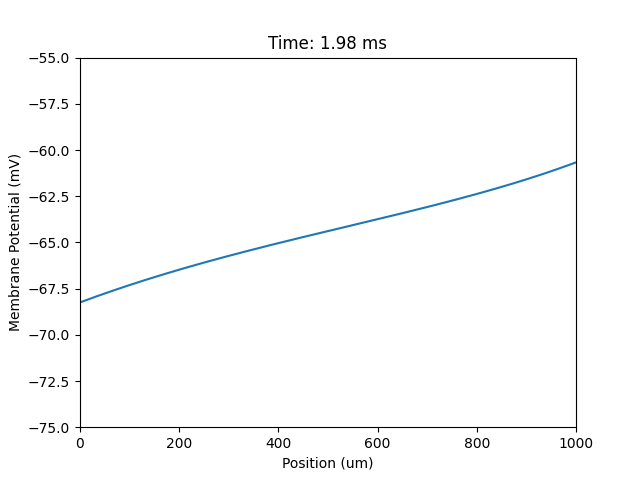

In [4]:
diam = 10
l = 1000
nseg = 1001
duration = 2
amp = 10
width = 100
ylim = (-75, -55)

with suppress_stdout():
    range_frames = simple_neuron_sim(diam, l, nseg, duration, amp, width)
ani = plot_voltage_movie(range_frames, l, ylim)
ani.save('simple_neuron/polarization.gif', writer='Pillow')

MovieWriter Pillow unavailable; using Pillow instead.


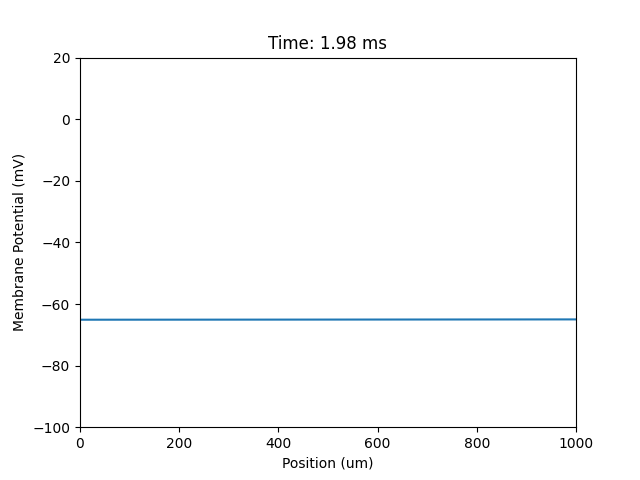

In [10]:
diam = 10
l = 1000
nseg = 1001
duration = 2
amp = 200
width = 0.1
ylim = (-100, 20)

with suppress_stdout():
    range_frames = simple_neuron_sim(diam, l, nseg, duration, amp, width)
ani = plot_voltage_movie(range_frames, l, ylim)
ani.save('simple_neuron/spiking.gif', writer='Pillow')